### Portfolio of Oil Exploration Assets: Learning Options, Sequential Drilling Options and Defer Options 
####  Marco Antonio Guimarães Dias, 
#### Luigi de Magalhães Detomi Calvette
##### RO Congress - Boston 2017


[Paper](http://www.realoptions.org/openconf2017/data/papers/57.pdf)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sci
from scipy.stats import norm
import time
import winsound

In [2]:

duration = 2000  # milliseconds
freq = 440  # Hz

In [3]:
#Importar Case 
case=pd.read_csv("Case_Guy_DogFish.csv", sep=';')
case.set_index('Type', inplace=True)
case=case.astype(float).T
case

Type,DogFish
CF,0.30
I_w,80.00
q,0.15
B,450.00
Owner,1.00


In [4]:
###Dados de Entrada###
r=0.03
delta=0.038
sigma=0.3
tau=3
P=50
rho=0.6
CF=case.iloc[0,0]
q=case.iloc[2,0]
#B=case.iloc[3,0]
B=620
Iw=case.iloc[1,0]
Id=case.iloc[3,0]*5.35 + 650

In [5]:
def sinal(CF,rho):
    CF_s=CF +(1-CF)*rho
    CF_ins=CF*(1-rho)
    return CF_ins,CF_s


In [6]:
def carteira(CF,q,P,B,delta,Id,Iw,r):
    #VPL=P*case.iloc[2,0]*case.iloc[3,0] - (case.iloc[3,0]*5.35 + 650)*P/50
    VPL=P*q*B*np.exp(-2*delta) - Id*np.exp(-2*r)
    #c=0.047*P+3
    #VPL=P*case.iloc[2,0]*case.iloc[3,0] - (case.iloc[3,0]*c + 650)
    
    vme=CF*VPL - Iw
    #vme=np.maximum(0,vme)
    ### retorna   VME, Valor, Investimento, (valor - FC*Id), Id+Iw
    return vme, CF*VPL, Iw, CF*P*q*B,CF*Id*np.exp(-2*r) +Iw 

In [7]:
carteira(CF,q,P,B,delta,Id,Iw,r)

(349.0750897201862, 429.0750897201862, 80.0, 1395.0, 943.8335184301521)

In [8]:
#####Valor Beta e Valor Crítico####
def vcritico(I,r,div,sigma,tau):
    if tau <=0:
        vcrit=I
        beta= 0.5 -(r-div)/(sigma**2) + np.sqrt(np.power(((r-div)/(sigma**2)) - 0.5,2) +((2*r)/(sigma**2)))
    else:
        if div<=0:
            print("Faça um BSM")
        else:
            
            beta= 0.5 -(r-div)/(sigma**2) + np.sqrt(np.power(((r-div)/sigma**2) -0.5,2) +((2*r)/(sigma**2)))
            V_perp= I*(beta/(beta-1))
            V_0=np.maximum(I, (r/div)*I)
            ht= -1*((r-div)*tau + 2*sigma*np.sqrt(tau))*(V_0/(V_perp - V_0))
            vcrit= V_0 + (V_perp - V_0)*(1- np.exp(ht))
    return[beta,vcrit, V_perp]
            
        
        

In [9]:
####Método Black Merton e Scholes
def bsm(V,I,r,div,sigma,tau):
    #Opção de Compra Europeia com dividendos - Merton
    

    if tau <=0:
        call=np.maximum(V-I,0)
        put=np.maximum(I-V,0)
    else:
        h1=(np.log(V/I) + ((r-div) +(0.5*np.power(sigma,2)))*tau)/(sigma*np.sqrt(tau))
        h2=h1 -sigma*np.sqrt(tau)
        
        call= V*np.exp(-div*tau)*norm.cdf(h1) -I*np.exp(-r*tau)*norm.cdf(h2)
        put= call + (np.exp(-r*tau)*I - V*np.exp(-div*tau))
        put2= I*np.exp(-r*tau)*(1- norm.cdf(h2)) - V*np.exp(-div*tau)*(1-norm.cdf(h1))
    #return[call, put, norm.cdf(h1), norm.cdf(h2),put2]
    return[call, put]





In [10]:
###Função probabilidade para cálculo do gatilho pelo método de aproximação analítica
def prob(V,tau,gama,h,vcrit,r,div,sigma):
    ####Função probabilidade
    lamba=(-r +(gama*(r-div)) +0.5*gama*(gama-1)*sigma**2)*tau
    dist= -(np.log(V/h)+((r-div)+(gama - 0.5)*sigma**2)*tau)/(sigma*np.sqrt(tau))
    kappa= (2*gama -1) +  2*(r-div)/(sigma**2)
    prob=np.exp(lamba)*(V**gama)*(norm.cdf(dist) - ((vcrit/V)**kappa)*(norm.cdf(dist -(2*np.log(vcrit/V))/(sigma*np.sqrt(tau)))))
    
    return[prob]
    

In [11]:
### Método Bjerksund e Stensland (1993) - saida - Derivativo, Gatilho e V_0
def bjst(V,I,r,div,sigma,tau):
    #### Call americana
    if div <=0: #igual a call europeia
        bs=bsm(V,I,r,div,sigma,tau)[0]
    else:
        beta=vcritico(I,r,div,sigma,tau)[0]
        vcrit=vcritico(I,r,div,sigma,tau)[1]
        alpha= (vcrit - I)*vcrit**(-beta)
        
        if V>= vcrit:
            bs=V-I
        else:
            bs= alpha*V**beta -alpha*prob(V,tau,beta,vcrit,vcrit,r,div,sigma)[0]+prob(V,tau,1,vcrit,vcrit,r,div,sigma)[0]-prob(V,tau,1,I,vcrit,r,div,sigma)[0]-I*prob(V,tau,0,vcrit,vcrit,r,div,sigma)[0]+I*prob(V,tau,0,I,vcrit,r,div,sigma)[0]
    
    return[bs, vcrit, V]
    
    

In [12]:
##################################################3
#####################################################
###########Solucao e_ DF ##############


In [13]:
def diffinexpcart(P,I,r,div,sigma,tau,accur):
    #############################################################
    #######Método por diferenças finitas explícitas##############
    #accur=0.05  #Porcentagem de acurácia
    
    #####Solução por diferenças finita explícitas###
    #Precisão em e intervalo da célula em V
    deltaP=P*accur
    
    # M são as divisões do grid em V
    #Perpetuidade vcritico não esta na programacao
    #M= int(1.1*vcritico(I,r,div,sigma,tau)[2]/deltaV) # Max é 10% acima do gatilho em perpetuidade. Vcrit- com gati precisa de tau
    M=int(2*vcritico(I,r,div,sigma,tau)[2]/deltaP)
    #PGrid=int(P/deltaP) #Ponto do grid onde esta P_0. 
    #deltat= (deltaP**2)/((sigma**2)*((3*I)**2)) #Convergência: Critério do peso central >=0. Pmax=3I ><1.1Gatilho_perp
    deltat= (deltaP**2)/((sigma**2)*((3*I)**2))
    N= int(tau/deltat) +1
    
    df=1/(1+(r*deltat)) # fator de desconto
    
    
    #Vetor Pt
    Pt=np.zeros(M+1)
    Gatilho=np.zeros((N+1))
    F=np.zeros((N+1,M+1))
    deltat=tau/N
    for i in range(M+1):
        Pt[i]= i*deltaP
        F[N,i]=np.maximum(Pt[i]-I,0) 
    Gatilho[N]=I
        #Gatilho[N]=I
    
    
    #print(PGrid,Pt.shape)
    PGrid=np.where(np.round(Pt,2)==np.round(P,2))[0][0]
    ##############Loop################
    for j in range(N-1,-1,-1): #de N-1 até zero(-1) pulando em -1
        for i in range(1,M,1): # de 1 até M-1 pulando em 1
            pu= 0.5*((sigma**2)*(i**2) + ((r - div)*i))*deltat
            pm = 1 - (sigma**2)*(i**2)*deltat
            pdown = 0.5*((sigma**2)*(i**2) - ((r - div)*i))*deltat
            F[j,i]= df*(pu*F[j+1,i+1] + pm*F[j+1,i] + pdown*F[j+1,i - 1])
            
            ###Vetor Gatilho####
            if F[j,i]<Pt[i]-I  and F[j,i-1]>Pt[i-1]-I :
                Gatilho[j]=(Pt[i-1] +Pt[i])*.5
            F[j,i]=np.maximum(Pt[i]-I,F[j,i])
            
           
        
        F[j,0]=0
        F[j,M]=Pt[i]-I
        
    T=np.linspace(0,tau,num=N+1)
    return[F[0,PGrid],PGrid,F,T,Pt,Gatilho]



In [14]:
accur=0.005

In [15]:

V_cf=CF*P*q*B*np.exp(-2*delta)
Id_cf=CF*Id*np.exp(-2*r)


In [16]:
start=time.time()
opcao,PGrid,mapa,tempo,preco,gatilho=diffinexpcart(V_cf,Id_cf+Iw,r,delta,sigma,tau,accur)
cpu=time.time()-start
print('minutos-',cpu/60)

winsound.Beep(freq, duration)


minutos- 11.158386623859405


In [17]:
V_cf, preco[PGrid]

(1292.9086081503383, 1292.9086081503383)

In [18]:
preco=preco/(CF*q*B*np.exp(-2*delta))

In [19]:
g=gatilho/(CF*q*B*np.exp(-2*delta))

gatilho é: 72.87500000000001
opcao vale: 407.4722171680524


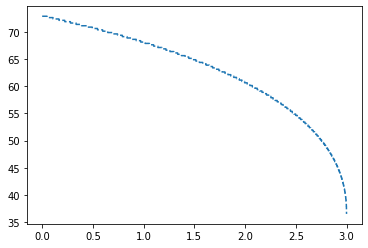

In [20]:
print('gatilho é:',gatilho[0]/(CF*q*B*np.exp(-2*delta)))
print('opcao vale:', opcao)
#plt.plot(tempo[:-1],g[:-1], ls='--')
plt.plot(tempo,g, ls='--')


(-5, 80)

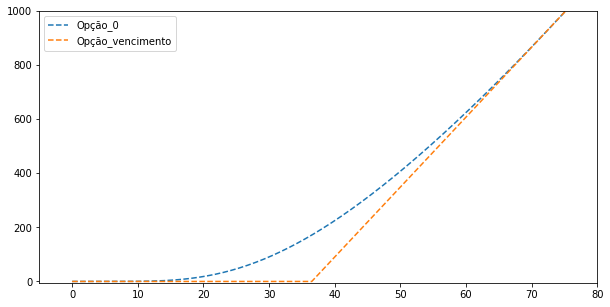

In [21]:
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(preco,mapa[0,:], ls='--')

#ax.plot(preco,venc, ls='--')
ax.plot(preco,mapa[-1,:], ls='--')

plt.legend(['Opção_0','Opção_vencimento'])
ax.set_ylim(-5,1000)
ax.set_xlim(-5,80)



In [22]:

V_inv=P*q*B*np.exp(-2*delta)
Id_inv=Id*np.exp(-2*r)


In [23]:
start=time.time()
opcao_inv,PGrid_inv,mapa_inv,tempo_inv,preco_inv,gatilho_inv=diffinexpcart(V_inv,Id_inv,r,delta,sigma,tau,accur)
cpu=time.time()-start
print('minutos-',cpu/60)
winsound.Beep(freq, duration)



minutos- 8.635280478000642


In [24]:
V_inv, preco_inv[PGrid_inv]

(4309.695360501128, 4309.695360501128)

In [25]:
preco_inv=preco_inv/(q*B*np.exp(-2*delta))

In [26]:
g_inv=gatilho_inv/(q*B*np.exp(-2*delta))

gatilho é: 66.87500000000001
opcao vale: 1538.9266889344397


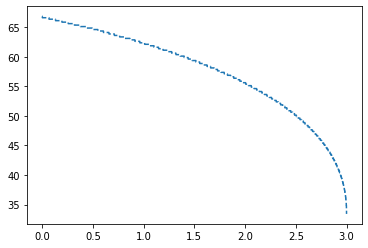

In [27]:
print('gatilho é:',g_inv[0])
print('opcao vale:', opcao_inv)
#plt.plot(tempo[:-1],g[:-1], ls='--')
plt.plot(tempo_inv,g_inv, ls='--')


(-5, 80)

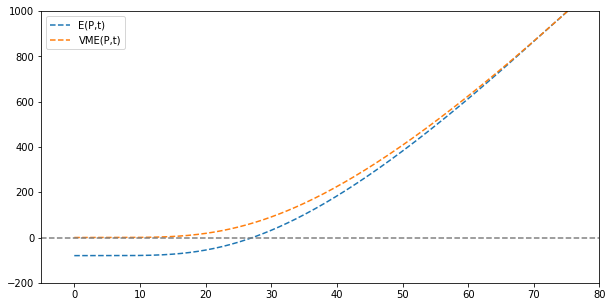

In [71]:
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(preco_inv,CF*mapa_inv[0,:] - Iw, ls='--')

ax.plot(preco,mapa[0,:], ls='--')
ax.axhline(0, linestyle='--', color='grey')


#ax.plot(preco,venc, ls='--')
#ax.plot(preco_inv/(0.1*300*np.exp(-2*delta)),mapa_inv[-1,:], ls='--')

plt.legend(['E(P,t)','VME(P,t)'])
ax.set_ylim(-200,1000)
ax.set_xlim(-5,80)

#ax.set_ylim(933,938)
#ax.set_xlim(72.6,72.8)




In [29]:
VME=CF*opcao_inv -Iw
print(VME)
print(g_inv[0])

381.67800668033186
66.87500000000001


In [30]:
if P>g[0]:
    custo=VME*(1-np.exp(-r/12))
else:
    custo=0

In [31]:
sinal(CF,rho)

(0.12, 0.72)

In [32]:
start=time.time()

opcao_up,PGrid_up,mapa_up,tempo_up,preco_up,gatilho_up=diffinexpcart(sinal(CF,rho)[1]*P*q*B*np.exp(-2*delta),sinal(CF,rho)[1]*(4*B + 600)*np.exp(-2*r)+Iw,r,delta,sigma,tau,accur)
opcao_down,PGrid_down,mapa_down,tempo_down,preco_down,gatilho_down=diffinexpcart(sinal(CF,rho)[0]*P*q*B*np.exp(-2*delta),sinal(CF,rho)[0]*(4*B + 600)*np.exp(-2*r)+Iw,r,delta,sigma,tau,accur)
opcao_info=CF*opcao_up + (1-CF)*opcao_down

cpu=time.time()-start
print('minutos-',cpu/60)
winsound.Beep(freq, duration)



minutos- 26.28532577753067


In [33]:
preco_up=preco_up/(sinal(CF,rho)[1]*q*B*np.exp(-2*delta))
preco_down=preco_down/(sinal(CF,rho)[0]*q*B*np.exp(-2*delta))

In [34]:
F_up_zero=np.interp(preco_inv,preco_up,mapa_up[0,:])
F_down_zero=np.interp(preco_inv,preco_down,mapa_down[0,:])
F_zero=CF*F_up_zero+ (1-CF)*F_down_zero

Exp_zero=np.interp(preco_inv,preco,mapa[0,:])

L_zero=CF*mapa_inv[0,:] - Iw


In [48]:
preco_inv[np.where(L_zero==Exp_zero)[0][0]]

77.00000000000001

In [35]:
F_zero.shape, Exp_zero.shape

((716,), (716,))

In [36]:
U=np.maximum(0, L_zero+ F_zero)

In [37]:
U[np.where(np.round(preco_inv,2)==np.round(P,2))[0][0]]

787.7000316736087

In [38]:
np.where(np.round(preco_inv,2)==np.round(P,2))[0][0]
print(preco_inv[np.where(np.round(preco_inv,2)==np.round(P,2))[0][0]])

50.00000000000001


In [39]:
w_i=0.5

In [40]:
U_i=U*w_i

In [41]:
preco[np.where(U_i>0)[0][0]]

23.250000000000004

gatilho explorar hoje é: 72.88
gatilho investir hoje é: 66.88


[]

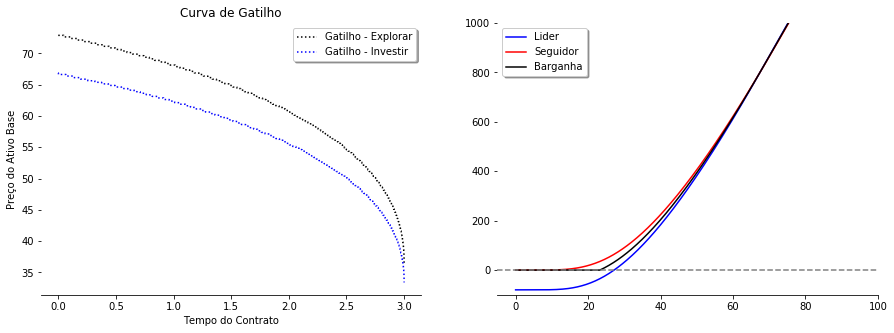

In [73]:
#####Figuras de Gatilho e a#####
fig, (ax1,ax2)= plt.subplots(1,2, figsize=(15,5))
sns.despine(left=True)

print('gatilho explorar hoje é:',round(gatilho[0]/(CF*q*B*np.exp(-2*delta)),2))
print('gatilho investir hoje é:',round(gatilho_inv[0]/(q*B*np.exp(-2*delta)),2))

ax1.plot(tempo,g, color='black', ls=':' )
ax1.plot(tempo_inv,g_inv, color='blue', ls=':' )

ax1.legend(['Gatilho - Explorar','Gatilho - Investir'], loc='upper right', shadow=True)

ax1.set_xlabel('Tempo do Contrato')
ax1.set_ylabel('Preço do Ativo Base')
#ax1.set_xticklabels([0,1000,2000,5000,10000,50000,100000])
ax1.set_title('Curva de Gatilho')


ax2.plot(preco_inv,L_zero, color='blue', ls='-' )
ax2.plot(preco_inv,F_zero, color='red', ls='-' )
ax2.plot(preco_inv,U_i,color='black',ls='-')
ax2.axhline(0, linestyle='--', color='grey')

ax2.set_ylim(-20,250)
ax2.set_xlim(-5,120)

#ax2.plot(V_vetor,F_V_Matrix[F_V_Matrix.shape[0]-1,:], color='blue', ls='--' )

ax2.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
#ax2.set_xlabel('Preço do Ativo Base')
#ax2.set_ylabel('Valor da Opção')
ax2.set_xlim(right=100)
ax2.set_ylim(top=1000)
ax2.set_ylim(bottom=-100)
#ax2.set_title('Opção de Investir em função do Preço')

plt.plot()

In [ ]:
########################Guerra de Atrito##############################3

In [155]:
print(opcao)
print(opcao_info)

407.4659318424228
406.01776459109726


In [156]:
import nashpy as nash

In [157]:
A=[[opcao-custo,opcao_info],[VME, VME]]
A=np.round(A,2)

In [158]:
B=[[opcao-custo,VME],[opcao_info, VME]]
B=np.round(B,2)

In [159]:
war_att=nash.Game(A,B)
war_att

Bi matrix game with payoff matrices:

Row player:
[[407.47 406.02]
 [381.68 381.68]]

Column player:
[[407.47 381.68]
 [406.02 381.68]]

In [160]:
eq=list(war_att.support_enumeration())
eq

[(array([1., 0.]), array([1., 0.]))]

In [ ]:
g[0]

In [161]:
for s1,s2 in eq:
    row_util=np.dot(np.dot(s1,A),s2)
    col_util=np.dot(np.dot(s1,B),s2)
    print(row_util,col_util)

407.47 407.47


In [545]:
###################################Barganha##############################################

In [27]:
# bjst(V,I,r,div,sigma,tau):
#valor da opção
bjst(V,Iw+Id,r,delta,sigma,2)

[137.16098032863027, 529.1513032482706, 542.9024508215757]

In [28]:
vcritico(Iw+Id,r,delta,sigma,tau)[1]/(0.2*0.1*300*np.exp(-2*delta))

97.46710526863609

In [29]:
# bjst(V,I,r,div,sigma,tau):
#valor da opção
bjst(V,Iw+Id,r,delta,sigma,2)[1]/(0.2*0.1*300*np.exp(-2*delta))

97.46710526863609

In [30]:
opcao - bjst(V,Iw+Id,r,delta,sigma,2)[0]

NameError: name 'opcao' is not defined